---
**Turma**: 15

**Grupo**: 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`

**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

### Objetivo:

 Quais seriam as outras abordagem para segmentação dos clientes do ifood?

### Etapas:

1) Carregar ABT (analytical base table) e importar tabelas

2) Seleção de variáveis

3) Tratamento de missing

4) Modelagem com K-means

5) Selecionando o K ótimo com o método Elbow e Silhoutte Score

6) Análise descritiva dos K clusters

### 1) Carregando Analytical base table

In [0]:
from pyspark.ml.feature import VectorAssembler,StandardScaler,RobustScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
root_dir = '/dbfs/FileStore/ifood'
dbutils.fs.ls(f'{root_dir}')


pedidos = spark.read.parquet(f'{root_dir}/enrich/orders').repartition(2).cache()
display(pedidos)

customer_id_x,mes_pedido,cohort_month,months_after_first_purchase,avg_order_total,sum_order_total,avg_credit,sum_credit,avg_paid_amont,sum_paid_amount,sum_promo_items_quantity,avg_distance_merchant_customer,avg_normal_items_quantity,sum_normal_items_quantity,avg_order_lag_at_login,sum_order_lag_at_login,avg_order_lead_at_login,sum_order_lead_at_login,avg_general_net_profit,sum_general_net_profit,avg_hora_pedido,avg_lat_customer,avg_log_customer,sunday,monday,tuesday,wednesday,thurday,friday,saturday,breakfast,dawn,dinner,lunch,snack,weekend,midweek,count_orders
23651daac69b3c56a70e95aaca63baec95c00e7dee3242ba6297e1dc77556208,10,4,6.0,39.8125,318.5,14.0,112.0,25.8125,206.5,4.0,1912.94693182427,0.5,4.0,4.625,37.0,4.125,33.0,-7.119755322312517,-56.958042578500134,11.375,-23.56,-46.65,0,1,1,1,4,1,0,0,0,0,8,0,0,8,8
0eff1953f14ba1116fd545a062ead9bff09878f1ff4bd26c715058a65286174b,9,12,33.0,69.4225,555.38,5.875,47.0,64.785,518.28,1.0,1761.1797193317734,2.125,17.0,4.75,38.0,7.125,57.0,10.507145625,84.057165,18.0,-19.97,-44.19,0,1,0,2,2,2,1,0,0,7,1,0,3,5,8
ed13c5fdc87d16df785813fd4d96ef07f403dbe48f83060487ae58bf65a3320d,8,4,16.0,82.33333333333333,247.0,4.0,12.0,78.33333333333333,235.0,0.0,2223.420487537975,3.0,9.0,10.666666666666666,32.0,17.0,51.0,12.384,37.152,19.666666666666668,-22.89,-43.580000000000005,0,0,0,0,1,1,1,0,0,3,0,0,2,1,3
243cea811eb50506d170712e47345c304bef75ed0022e5c4f185b5bf575e6212,7,11,8.0,34.0,34.0,4.0,4.0,30.0,30.0,0.0,1773.8019298291515,1.0,1.0,9.0,9.0,133.0,133.0,7.236499999999999,7.236499999999999,21.0,-16.7,-49.3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
130a1acfa04c1e421a4efa779cfedbda06b3bf5ef00635e88b31b0c84974424d,6,10,44.0,78.95,157.9,4.0,8.0,74.95,149.9,0.0,3127.3647780273513,1.5,3.0,17.0,34.0,13.0,26.0,6.594860414593378,13.189720829186756,15.5,-13.0,-38.515,1,0,0,1,0,0,0,0,0,1,1,0,1,1,2
2df01315f6fd10b7c4bccc5790ddef44926141c1c3eb461129604540739f9fb7,6,9,57.0,124.80000000000001,249.60000000000002,4.0,8.0,120.80000000000001,241.60000000000002,0.0,2821.26650518654,5.0,10.0,15.5,31.0,11.0,22.0,11.917625,23.83525,20.5,-23.55,-46.69,1,0,0,1,0,0,0,0,0,2,0,0,1,1,2
a9025d966af7870ccf1bb2644f6e62b3f4ea24d4ff0bc808f2d908ea32e118e3,7,12,19.0,51.2,51.2,4.0,4.0,47.2,47.2,0.0,1523.7859481260014,2.0,2.0,19.0,19.0,39.0,39.0,7.03415,7.03415,22.0,-23.6,-46.5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
773db0ff011e9ac7473cb074f056a8dc0d548c3c1510c244fc6a68c9299daf77,7,3,16.0,29.975,119.9,10.9775,43.91,18.997500000000002,75.99000000000001,5.0,912.7271493736514,0.0,0.0,8.25,33.0,2.25,9.0,-2.7630109808882075,-11.05204392355283,11.75,-23.58,-46.72,0,0,1,0,1,2,0,0,0,0,4,0,0,4,4
882c7baaa77438f45c4df253b55dd652fe0cc9179f798f84bc7f9f3a9966d259,6,6,24.0,51.835,1036.7,4.5,90.0,47.334999999999994,946.6999999999999,7.0,1572.116817001014,2.15,43.0,1.25,25.0,1.4,28.0,7.220102249664665,144.4020449932933,17.65,-9.652500000000002,-35.7085,2,2,5,2,3,2,4,0,0,13,6,1,7,13,20
37ce7273338561898e5a0dd8597b44bbd3973e6a6744e101fa4835afceb9c760,8,4,16.0,31.345454545454547,344.8,10.536363636363637,115.9,20.809090909090912,228.90000000000003,9.0,2052.759832360364,0.9090909090909091,10.0,2.909090909090909,32.0,2.909090909090909,32.0,-7.0760142947750815,-77.8361572425259,13.909090909090908,-30.014545454545456,-51.16818181818181,0,1,3,1,3,1,2,0,0,2,7,2,2,9,11


### 2) Seleção de variáveis

In [0]:
numericas = [
  #'customer_id_x',
 #'mes_pedido',
 #'cohort_month',
 #'months_after_first_purchase',
 #'avg_order_total',
 #'sum_order_total',
 #'avg_credit',
 'sum_credit',
 #'avg_paid_amont',
 #'sum_paid_amount',
 #'avg_distance_merchant_customer',
 #'avg_normal_items_quantity',
 'sum_normal_items_quantity',
  'sum_promo_items_quantity',
 #'avg_order_lag_at_login',
# 'sum_order_lag_at_login',
 #'avg_order_lead_at_login',
# 'sum_order_lead_at_login',
 #'avg_general_net_profit',
 'sum_general_net_profit',
 #'avg_hora_pedido',
 #'avg_lat_customer',
 #'avg_log_customer',
 #'sunday',
# 'monday',
# 'tuesday',
 #'wednesday',
# 'thurday',
 #'friday',
# 'saturday',
 #'breakfast',
 #'dawn',
 #'dinner',
# 'lunch',
 #'snack',
 #'acai',
 #'comida_brasileira',
 #'comida_japonesa',
 #'comida_saudavel',
 #'lanches',
# 'pizza',
 'weekend',
 'midweek',
 #'count_orders'
]

df = pedidos[numericas]

#### Correlação entre as variáveis selecionadas

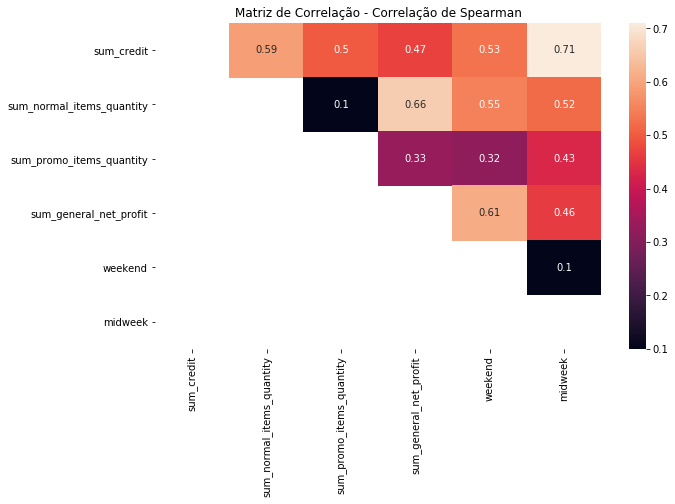

In [0]:
### Correlação

correlação = round(df.toPandas().corr(method='spearman'),2)
triangulo = correlação.where(np.triu(np.ones(correlação.shape), k=1).astype(np.bool))

#Criando uma representação gráfica para a matriz de correlação
sns.heatmap(triangulo, 
            xticklabels=correlação.columns.values,
            yticklabels=correlação.columns.values,annot=True)

plt.title('Matriz de Correlação - Correlação de Spearman')
plt.gcf().set_size_inches(10,6)
plt.show()

### 3) Tratamento de missing

In [0]:
df.toPandas().isnull().sum().reset_index()

,index,0
0,sum_credit,0
1,sum_normal_items_quantity,1
2,sum_promo_items_quantity,1
3,sum_general_net_profit,0
4,weekend,0
5,midweek,0


In [0]:
df = df.dropna()
df.toPandas().isnull().sum().reset_index()

,index,0
0,sum_credit,0
1,sum_normal_items_quantity,0
2,sum_promo_items_quantity,0
3,sum_general_net_profit,0
4,weekend,0
5,midweek,0


### 4) Modelagem com K-means


- Criação do vector assembler
- Padronização das variáveis

##### Criando o vetor com as features (VectorAssembler)

In [0]:
df2 = VectorAssembler().setInputCols(numericas).setOutputCol('features').transform(df)      

##### Padronizando as variáveis

In [0]:
scaler = RobustScaler(
  inputCol="features",
  outputCol="scaledFeatures",
  withScaling=True,
  withCentering=False,
  lower=0.01,
  upper=0.99
)

scalerModel = scaler.fit(df2)
scaledData = scalerModel.transform(df2)

### 5) Selecionando o K ótimo com o método Elbow e Silhoutte Score

In [0]:
#Elbow
n_clusters = []
custo = []

#Silhoutte score 
cost = list()
evaluator = ClusteringEvaluator()

for i in range(3, 8):
  kmedias = KMeans(featuresCol='scaledFeatures').setK(i).setSeed(42)
  modelo = kmedias.fit(scaledData)
  #Elbow
  n_clusters.append(i)
  custo.append(modelo.summary.trainingCost)
  
  #silhoutte score
  tags_predictions = modelo.transform(scaledData)
  silhouette = evaluator.evaluate(tags_predictions)
  cost.append(silhouette)

#### Método Elbow

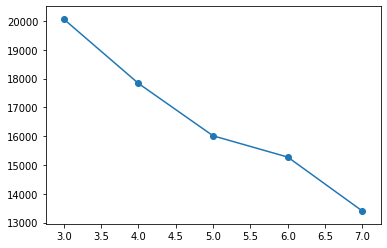

In [0]:
plt.plot(n_clusters, custo)
plt.scatter(n_clusters, custo)
display(plt.show())

#### Silhoutte scores

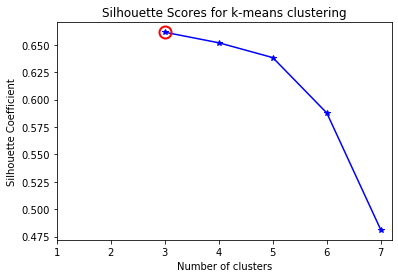

In [0]:
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(3,8), cost, 'b*-')
plt.plot(range(3,8)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

#### K Means

In [0]:
best_k = 3

kmedias = KMeans(featuresCol='scaledFeatures').setK(best_k).setSeed(42)

modelo = kmedias.fit(scaledData)

predicoes = modelo.transform(scaledData)

#### Número de observações por cluster

In [0]:
display(predicoes.groupby('prediction').count())

prediction,count
1,4299
2,27721
0,100327


### 6) Análise descritiva dos novos clusters


- ##### Cluster 0  (100.327)

- ##### Cluster 1 (4.299)

- ##### Cluster 2 (27.721)

In [0]:
predicoes = predicoes.toPandas()
predicoes.groupby('prediction').agg(['mean','median'])

sum_credit 
 sum_normal_items_quantity 
 sum_promo_items_quantity 
 sum_general_net_profit 
 weekend 
 midweek 
 
 
 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 
 
 prediction 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 12.655192 
 8.0 
 3.004675 
 2.0 
 0.857227 
 0.0 
 15.187975 
 12.652000 
 1.010585 
 1 
 1.076330 
 1 
 
 
 1 
 122.477492 
 100.0 
 34.578507 
 29.0 
 10.031170 
 7.0 
 136.326611 
 132.723625 
 6.876250 
 6 
 11.487555 
 11 
 
 
 2 
 46.301378 
 38.0 
 11.880271 
 10.0 
 3.707478 
 3.0 
 55.185375 
 53.887873 
 3.280149 
 3 
 4.071246 
 4

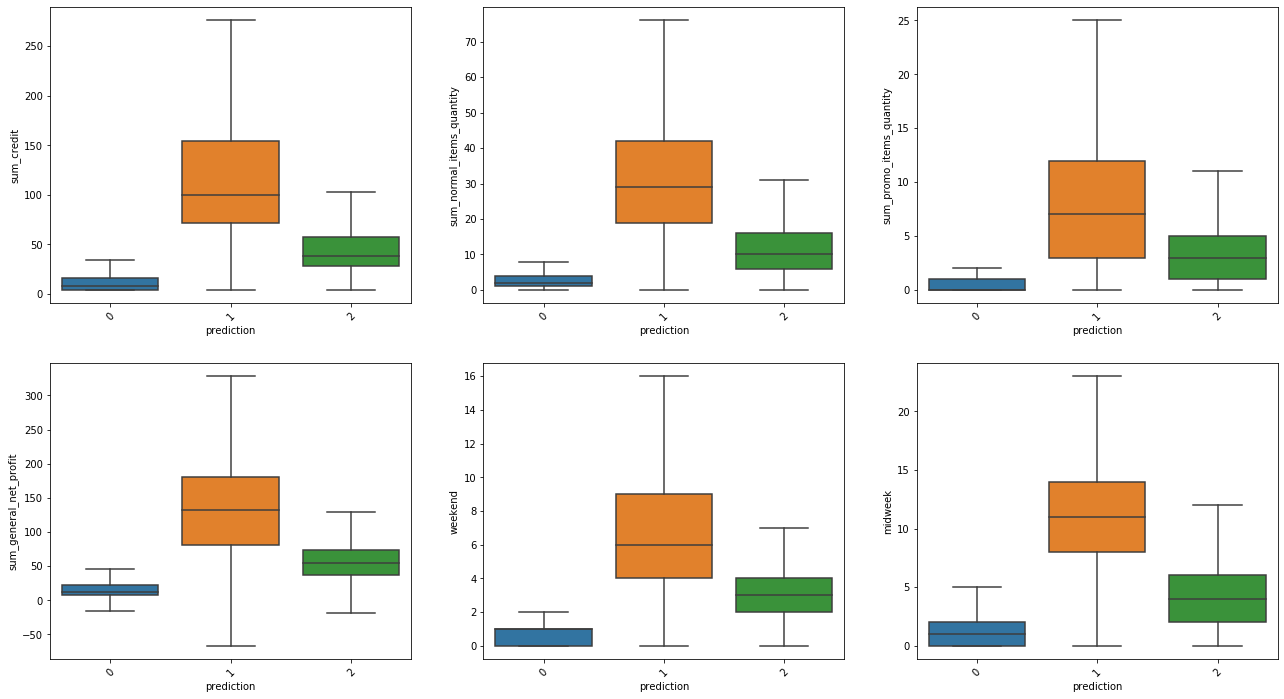

In [0]:
categorical = numericas
fig, ax = plt.subplots(len(categorical), 3, figsize=(22, 12))

for i, col in enumerate(categorical):
  plt.subplot(2, 3, i+1)
  plt.xlabel(col, fontsize=10)
  plt.xticks(rotation=45)

  sns.boxplot(x='prediction',
    y = col,
    data=predicoes,
    dodge=False,
    showfliers=False #
  )

plt.show()